**Author**: Min  
**Date**: December 31, 2019  
**Approach**: Implemented XGBoost classifier, determined optimal threshold value to maximize F1 score, and used stratified 5-fold cross-validation to estimate the AUC.  
**Estimated AUC**: 0.8456

## 1. I/O + Preprocessing

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train['gender'] = train['gender'].map({'M': 1, 'F': 0})
df = pd.get_dummies(train, columns=['device_type'])

X = df.drop('outcome', axis=1)
y = df['outcome']

test['gender'] = test['gender'].map({'M': 1, 'F': 0})
test_df = pd.get_dummies(test, columns=['device_type'])

## 2. Exploratory Data Analysis

#### The dependent variable, outcome, is highly imbalanced.

In [4]:
train['outcome'].value_counts(normalize=True)

0    0.9018
1    0.0982
Name: outcome, dtype: float64

#### The distributions between the train and test features appear to be similar.

In [5]:
df.describe()

,age,cost_of_ad,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,device_type_Android,device_type_desktop,device_type_iPhone,device_type_laptop,device_type_other
count,10000.000000,10000.000000,9731.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.0000,10000.000000,10000.0000,10000.0000,10000.000000,10000.000000
mean,37.991800,0.004666,0.489261,0.497500,58004.335800,1.497000,2.00220,5.406800,0.0982,0.202300,0.2032,0.1968,0.199100,0.198600
std,13.038203,0.000838,0.499910,0.500019,17330.778355,0.500016,0.81784,5.046014,0.2976,0.401735,0.4024,0.3976,0.399343,0.398966
min,16.000000,0.003171,0.000000,0.000000,16241.000000,1.000000,1.00000,0.000000,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000
25%,27.000000,0.003995,0.000000,0.000000,45533.500000,1.000000,1.00000,1.000000,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000
50%,38.000000,0.004625,0.000000,0.000000,58053.500000,1.000000,2.00000,4.000000,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000
75%,49.000000,0.005164,1.000000,1.000000,70235.250000,2.000000,3.00000,8.000000,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000
max,60.000000,0.007082,1.000000,1.000000,99956.000000,2.000000,3.00000,22.000000,1.0000,1.000000,1.0000,1.0000,1.000000,1.000000


In [6]:
test_df.describe()

,age,cost_of_ad,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,device_type_Android,device_type_desktop,device_type_iPhone,device_type_laptop,device_type_other
count,10000.000000,10000.000000,9751.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,38.029200,0.004668,0.496872,0.500900,58232.104800,1.486300,2.009100,5.319800,0.198300,0.200700,0.197900,0.195900,0.20720
std,12.896921,0.000836,0.500016,0.500024,17318.192722,0.499837,0.817242,5.019487,0.398739,0.400544,0.398436,0.396912,0.40532
min,16.000000,0.003173,0.000000,0.000000,16124.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,27.000000,0.004000,0.000000,0.000000,45575.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,38.000000,0.004609,0.000000,1.000000,58271.000000,1.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,49.000000,0.005175,1.000000,1.000000,70438.750000,2.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,60.000000,0.007049,1.000000,1.000000,99916.000000,2.000000,3.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## 3. Fit classification model

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2, random_state=30, stratify=y)

eval_set = [(X_train, y_train), (X_test, y_test)]

model = xgb.XGBClassifier(
    objective = 'binary:logistic', 
    eval_metric = 'auc',
    random_state = 1, 
    learning_rate = 0.05
)

model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', 
          eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='auc', gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

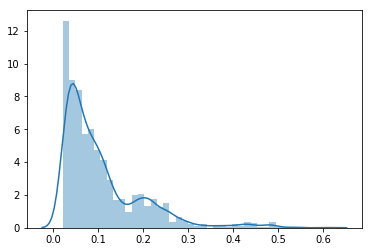

In [8]:
# Predict probabilities on test set
y_pred_prob = model.predict_proba(X_test)[:, 1]
sns.distplot(y_pred_prob)

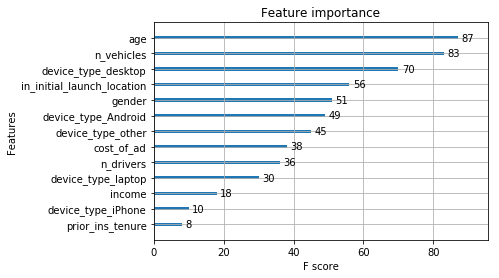

In [9]:
# Plot feature importances
xgb.plot_importance(model)

### 3.1 Compute ROC & AUC

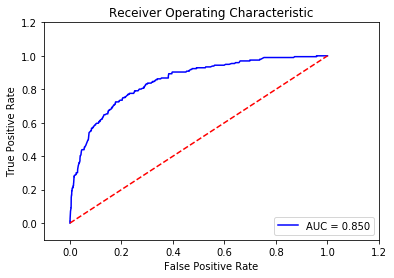

In [10]:
# Compute ROC metrics
fp, tp, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fp, tp)

# Plot ROC curve
plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fp, tp, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal threshold: 0.1468516


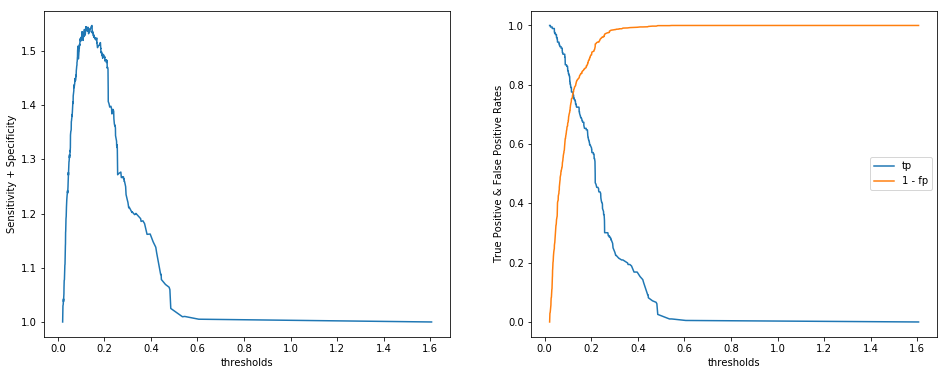

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].plot(thresholds, tp + (1 - fp))
ax[0].set_xlabel('thresholds')
ax[0].set_ylabel('Sensitivity + Specificity')

ax[1].plot(thresholds, tp, label="tp")
ax[1].plot(thresholds, 1 - fp, label="1 - fp")
ax[1].legend()
ax[1].set_xlabel('thresholds')
ax[1].set_ylabel('True Positive & False Positive Rates')

##finding the optimal threshold for the model
function = tp + (1 - fp)
index = np.argmax(function)

optimal_threshold = thresholds[np.argmax(function)]
print('optimal threshold:', optimal_threshold)

In [12]:
def binarize_by_threshold(values, threshold):
     return (np.where(values >= threshold, 1, 0))

y_pred = binarize_by_threshold(y_pred_prob, optimal_threshold)
accuracy_score(y_test, y_pred)

0.813

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.82      0.89      1804
           1       0.31      0.72      0.43       196

   micro avg       0.81      0.81      0.81      2000
   macro avg       0.64      0.77      0.66      2000
weighted avg       0.90      0.81      0.84      2000



### Estimate AUC using Stratified Cross-Validation

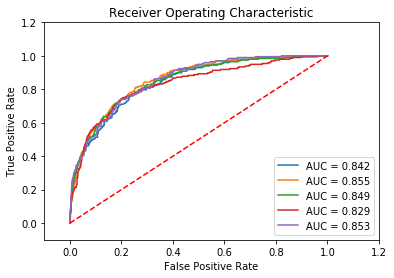

In [14]:
feature_cols = df.drop('outcome', axis=1).columns
# Configure cross validation
cv = StratifiedKFold(n_splits=5)

# Create new plot
plt.figure()

# Get indices for training and test subsets for each fold
for i, (training, testing) in enumerate(cv.split(df[feature_cols], df.outcome)):
    
    # Get training data
    X_train = df[feature_cols].values[training, :]
    y_train = df.outcome.values[training,]
    
    # Get test data
    X_test = df[feature_cols].values[testing, :]
    y_test = df.outcome.values[testing,]

    # Configure classifier
    clf = xgb.XGBClassifier(
        objective = 'binary:logistic', 
        eval_metric = 'auc',
        random_state = 1, 
        learning_rate = 0.05)
    
    # Learn classification model
    eval_set = [(X_train, y_train), (X_test, y_test)]
    clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', 
            eval_set=eval_set, verbose=False)
    
    # Get sample scores for ROC curve
    y_score = clf.predict_proba(X_test)
    
    # Compute ROC metrics
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score[:, 1], pos_label=1)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    # Plot ROC curve
    plt.plot(false_positive_rate, true_positive_rate, label='AUC = %0.3f'% roc_auc)

plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 4. Predict Test Output

In [15]:
binarize_by_threshold(model.predict_proba(test_df)[:,1], optimal_threshold)[:5]

array([0, 1, 0, 0, 0])